<a href="https://colab.research.google.com/github/jannisleu/DL4NLP/blob/main/Assignment%202/Group18_ASSIGNMENT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bag of Words Text Classification

In this assignment we will build a simple Bag of Words (BoW) text classifier using PyTorch. The classifier is trained on a Twitter dataset (with given labels) and is supposed to identify if the sentiment in individual tweets is *positive* or *negative*.


## Concepts covered in this assignment
1. NLP text pre-processing
2. Split of training, validation and testing datasets
3. Build a simple feed-forward neural net classifier using PyTorch
4. Training the model

As always, we start with some imports...




In [1]:
import random
import re # regular expression
from collections import Counter
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import google_drive_downloader
from google_drive_downloader import GoogleDriveDownloader as gdd
from IPython.core.display import display, HTML
from sklearn.metrics import classification_report
from tqdm import tqdm, tqdm_notebook # show progress bar

# PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

# nltk text processors
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.style.use('ggplot')
tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


device(type='cuda')

Next, we load our dataset.

In [ ]:
DATA_PATH = 'data/twitter_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='13OLqDXOBAO9fjD9Shz8iTeev3ZaNHaTC',
        dest_path=DATA_PATH,
    )

df = pd.read_csv(DATA_PATH)

**Let's see what we are working with...**

In [ ]:
print('Shape of the dataset' )
print(df.shape)

Shape of the dataset
(1000000, 3)


Below is a sample set of five random tweets and their classifications. The classifications are labeled "1" for positive and "0" for negative tweets.

In [ ]:
df.head(5)

,Unnamed: 0,tweet,label
0,0,is so sad for my APL frie...,0
1,1,I missed the New Moon trail...,0
2,2,omg its already 7:30 :O,1
3,3,.. Omgaga. Im sooo im gunna CRy. I'...,0
4,4,i think mi bf is cheating on me!!! ...,0


Let's see the distribution of positive and negative tweets. This is the data our classifier will be trained on later.

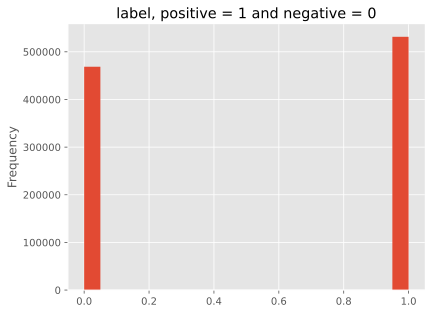

In [ ]:
df['label'].plot(kind='hist', bins=20, title='label, positive = 1 and negative = 0')
plt.gca().spines[['top', 'right',]].set_visible(False)

How about looking at specific examples for each class?

In [ ]:
print('Example negative tweet:')
print(df.loc[55,].tweet, '\n')
print('Example positive tweet:')
print(df.loc[12456,].tweet, '\n')

Example negative tweet:
  David must be hospitalized for five days end of July (palatine tonsils). I will probably never see Katie in concert.  

Example positive tweet:
*sigh*  sweet dreams guys...... 



Looking at your data before starting to code will help you in the process for example when encountering errors, when the training does not improve, or when you simply want to understand your results in the end. Remember: a good DL model is only as good as the data we feed it with!

# 1. Preprocessing
(2.5 Points - 0.5 for each subtask)<br>

As in the last assignment, we need to transform our data before training our classifier on it. We are interested to do the following preprocessing steps:
* Replace weird characters
* Lowercase
* Tokenize
* Stemming & Lemmatize
* Remove stopwords

**Let's see how to pre-process these steps one by one. Below we constructed a simple test tweet.**

In [ ]:
test_corpus = '''Curtain drops at the #Crown Uptown after 32 years http://www.kansas.com/news/featured/story/860875.html'''

<h1>Exercise 1.1</h1>
Write a function `special_and_lower` that removes special characters and puts the text lowercase. If you wonder what a special character is, check [here](https://www.computerhope.com/jargon/s/specchar.htm)


In [ ]:
# Your answer goes here
def special_and_lower(data):
  without_special =  ''.join(letter for letter in data if (letter.isalnum() or letter.isspace()))
  return without_special.lower()
test_corpus = special_and_lower(test_corpus)
print(test_corpus)

curtain drops at the crown uptown after 32 years httpwwwkansascomnewsfeaturedstory860875html


<h1>Exercise 1.2</h1>Write a function `tokenize_text` that creates a list of tokens from the input text. Use your own implementation here.

In [ ]:
# Your answer goes here
def tokenize_text(data):
  # Words independent of sentences
  tokens = data.split(' ')
  return tokens

test_corpus = tokenize_text(test_corpus)
print(test_corpus)

['curtain', 'drops', 'at', 'the', 'crown', 'uptown', 'after', '32', 'years', 'httpwwwkansascomnewsfeaturedstory860875html']


<h1>Exercise 1.3</h1>

Using  **WordNetLemmatizer** , write a function `lemmatize_text` that lemmatizes the text. Lemmatization, which is the process of grouping inflected forms together as a single base form, is a text normalization that is used in pre-processing. Please lemmatize first nouns and then verbs. For more information regarding *WordNetLemmatizer*, please check [here](https://www.nltk.org/_modules/nltk/stem/wordnet.html):


In [ ]:
# Your answer goes here
def lemmatize_text(data, lemmatizer):
  lemmatized_tokens = []
  for word, pos in pos_tag(data):
    if pos.startswith('N'):
      lemmatized_word = lemmatizer.lemmatize(word, pos='n')
    elif pos.startswith('V'):
      lemmatized_word = lemmatizer.lemmatize(word, pos='v')
    else:
      lemmatized_word = word
    lemmatized_tokens.append(lemmatized_word)
  return lemmatized_tokens

test_corpus = lemmatize_text(test_corpus, WordNetLemmatizer())
print(test_corpus)

['curtain', 'drop', 'at', 'the', 'crown', 'uptown', 'after', '32', 'year', 'httpwwwkansascomnewsfeaturedstory860875html']


<h1>Exercise 1.4 </h1>Write a function `replace_numbers` that replaces any standalone number with the special token " < NUM > " (without the spaces). For instance, "42" must be replaced by the token but "42h" not.




In [ ]:
# Your answer goes here
def replace_numbers(data):
  for i in range(len(data)):
    if data[i].isnumeric():
      data[i] = '<NUM>'
  return data
test_corpus = replace_numbers(test_corpus)
print(test_corpus)


['curtain', 'drop', 'at', 'the', 'crown', 'uptown', 'after', '<NUM>', 'year', 'httpwwwkansascomnewsfeaturedstory860875html']


<h1>Exercise 1.5</h1>We want to remove redundant words that are very common in all the texts (like "a" or "to"). As you learned previously, these words are called stopwords and do not contain any meaning, that is relevant for our task.
Write a function "remove_stopwords" that removes stopwords using the stopwords imported from NLTK (check on top).

In [ ]:
# Your answer goes here
stop_words = nltk.corpus.stopwords.words('english')
def remove_stopwords(data, stop_words):
    tmp = []
    for i in data:
        if i not in stop_words:
            tmp.append(i)
    return tmp
test_corpus = remove_stopwords(test_corpus, stop_words)
print(test_corpus)

['curtain', 'drop', 'crown', 'uptown', '<NUM>', 'year', 'httpwwwkansascomnewsfeaturedstory860875html']


# 2. Building a Vocabulary

Next we want to create some sort of represention for our tokens. As you encountered in the lecture, one way of doing this is by representing words by unique values and store them in a vocabulary. You will learn later why such a representation (or embedding) is not very efficient for larger text corpora. For the task at hand it is sufficient however.

<h1>Exercise 2.1</h1> (2 Points)<br> Define the function `build_vocab` which receives as input `clean_tokens` and returns `vocab`, which is a python dictionary with words as keys and unique integer indices as values.



In [ ]:
# Your answer goes here

def build_vocab(clean_tokens):
  vocab = dict()
  current_label = 0
  for tokens in clean_tokens:
    for token in tokens:
      if token not in vocab:
        vocab[token] = current_label
        current_label += 1

  return vocab
print(build_vocab([test_corpus]))

{'curtain': 0, 'drop': 1, 'crown': 2, 'uptown': 3, '<NUM>': 4, 'year': 5, 'httpwwwkansascomnewsfeaturedstory860875html': 6}


<h1>Exercise 2.2 </h1>(2 Points)<br> Define the function `build_index2token` which receives as input `vocab` (the output of the previously defined function `build_vocab`) and returns `index2token`, which is a python dictionary with unique integer indices as keys and  words as values. Make sure that the indices assigned to the words are exactly the same as in `vocab`.


In [ ]:
# Your answer goes here
def build_index2token(vocab):
    int_to_token = {v: k for k, v in vocab.items()}
    return int_to_token
print(build_index2token(build_vocab([test_corpus])))

{0: 'curtain', 1: 'drop', 2: 'crown', 3: 'uptown', 4: '<NUM>', 5: 'year', 6: 'httpwwwkansascomnewsfeaturedstory860875html'}


**Let's package the pre-processing steps together into one function to later apply it to our dataset.**<br>
(1 Point)



In [ ]:
def tokenize(text, stop_words, lemmatizer):

    # Complete this function by sending the data (text) through each of the functions you built above (special_and_lower, tokenize_text, replace_numbers, remove_stopwords, lemmatize text).
    # Think carefully about a sensible order!
    tokens = special_and_lower(text)
    tokens = tokenize_text(tokens)
    tokens = remove_stopwords(tokens, stop_words)
    tokens = replace_numbers(tokens)
    tokens = lemmatize_text(tokens, lemmatizer)

    return tokens

def build_bow_vector(sequence, idx2token):
    vector = [0] * len(idx2token)
    for token_idx in sequence:
        if token_idx not in idx2token:
            raise ValueError('Wrong sequence index found!')
        else:
            vector[token_idx] += 1
    return vector

# 3. Splitting and transforming the Dataset

<h1>Exercise 3.1</h1>
(3 points)

In this part, we will build a class to assign our data to. It helps us to easier access different parts of our dataset. But before doing so, we want you to do something else. Go to the `TwitterDataset` class and implement a function that assigns to the variable `common_tokens` the `n` most frequent/used words accross all tokens. `n` in this case is denoted as `max_vocab`.<br>

Make sure to use a function that compresses the output to a set of unique words, ie. disregard dublicates. If you're done with that, come back up here!

Next, we want you to implement a function `remove_rare_words` that will be called in the `TwitterDataset` class to remove rare words from each sequence of tokens in our dataset. As you can see, the function takes two arguments: a list of tokens, and a set of common_tokens (which is the variable you just filled in the previous task).

(1 point)

In [ ]:
def remove_rare_words(tokens, common_tokens):

    ''' input: list = tokens, set = common_tokens
    output: a list with only those tokens that can also be found among the most common tokens. all rare words are to be replaced with '<UNK>' '''
    for i in range(len(tokens)):
        if tokens[i] not in common_tokens:
          tokens[i] = '<UNK>'
    return tokens

Now we would like you to implement a function called `common_tokens`, that is called inside the class `TwitterDataset` and takes `all_tokens` to then return a set of most common words. The length of the set should be limited by the parameter `max_vocab`.

In [ ]:
from collections import Counter

def find_common_tokens(all_tokens, max_vocab):
  counter = Counter(all_tokens)
  common_tokens = [token for token, _ in counter.most_common(max_vocab)]
  return common_tokens
find_common_tokens(test_corpus, 4)

['curtain', 'drop', 'crown', 'uptown']

(1 point)

In [3]:
class TwitterDataset(Dataset):
    def __init__(self, data_path, max_vocab=5000):
        df = pd.read_csv(data_path)

        # Clean and tokenize
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        df['tokens'] = df.tweet.apply(
            partial(
                tokenize,
                stop_words=stop_words,
                lemmatizer=lemmatizer,
            ),
        )

        all_tokens = [token for doc in list(df.tokens) for token in doc]

        # This is where your function will be called
        common_tokens = find_common_tokens(all_tokens, max_vocab)

        # Replace rare words with <UNK>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(
            partial(
                remove_rare_words,
                common_tokens=common_tokens
            ),
        )

        # Replace numbers with <NUM>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(replace_numbers)

        # Remove sequences with only <UNK>
        df = df[df.tokens.progress_apply(
            lambda tokens: any(token != '<UNK>' for token in tokens),
        )]

        # Build vocab
        self.token2idx = build_vocab(list(df.tokens))
        self.idx2token = build_index2token(self.token2idx)


        # Convert tokens to indexes
        df['indexed_tokens'] = df.tokens.progress_apply(
            lambda doc: [self.token2idx[token] for token in doc],
        )
        #df["indexed_tokens"] = pd.to_numeric(df["indexed_tokens"], downcast="unsigned")
        #print(df.info(memory_usage='deep'))

        # Build BoW vector
        df['bow_vector'] = df.indexed_tokens.progress_apply(
            build_bow_vector, args=(self.idx2token,)
        )

        self.text = df.tweet.tolist()
        self.sequences = df.indexed_tokens.tolist()
        self.bow_vector = df.bow_vector.tolist()
        self.targets = df.label.tolist()

    def __getitem__(self, i):
        return (
            self.sequences[i],
            self.bow_vector[i],
            self.targets[i],
            self.text[i],
        )

    def __len__(self):
        return len(self.targets)

**Question**: Why might removing rare words not be a good idea? Why or when could rare words be valuable?

(1 point)

**Your answer goes here:**

It could be a bad idea to remove rare words because sometimes they can influence the meaning of the sentence significantly, especially while classifying sentences positivly and negativly. The removed word might be rare but could have such an impact on the meaning of the sentence that it is crucial for the differentiation between positive and negative. This might be the case with extremely positive words or extremely negative words that are rare.

Finally, we can instantiate our dataset.

In [2]:
MAX_VOCAB = "500" #@param [1000, 5000, 10000, 100000] {allow-input: true}

MAX_VOCAB = int(MAX_VOCAB)

In [ ]:
# This will load for a while: Grab a coffee
dataset = TwitterDataset(DATA_PATH, max_vocab=MAX_VOCAB)

100%|██████████| 999957/999957 [00:13<00:00, 74290.21it/s] 


Again, we can check a random sample out of the dataset.

In [4]:
#dumping files to save time
import pickle
from google.colab import drive
drive.mount('/content/drive')

# Create a folder in the root directory
#!mkdir -p "/content/drive/My Drive/DL4NLP"
#with open('/content/drive/My Drive/DL4NLP/twitter_dataset.pickle', 'wb') as f:
#   pickle.dump(dataset, f)
#f.close()

with open('/content/drive/My Drive/DL4NLP/twitter_dataset.pickle', 'rb') as f:
   dataset = pickle.load(f)
f.close()

Mounted at /content/drive


In [5]:
print('Number of records:', len(dataset), '\n')

import random
random_idx = random.randint(0,len(dataset)-1)
print('index:', random_idx, '\n')
sample_seq, bow_vector, sample_target, sample_text = dataset[random_idx]
print(sample_text, '\n')
print(sample_seq, '\n')
print('BoW vector size:', len(bow_vector), '\n')
print('label:', sample_target, '\n')

Number of records: 999957 

index: 382599 

@PrincessSuperC cann u c0ongraduate mii please!!!!  

[2, 2, 146, 2, 2, 73, 0] 

BoW vector size: 501 

label: 1 



<h1>Exercise 3.2</h1> (2 Points)<br> Split into training, validation, and test sets.

Since we only have a certain ammount of Data to train, validate and test our model on, we need to split our Dataset into 3 Parts:

- **Training**: data the model learns from (80%)
- **Validation**: data to evaluate with for hyperparameter tuning (make sure the model doesn't overfit!) (10%)
- **Testing**: data to evaluate the final performance of the model (10%)

Given the ratios for validation and testing, it is your task to complete the `function split_train_valid_test` and calculate the three split lenghts, which are then used as argument in the `random_split` function we have imported at the top of this notebook.

In [6]:
# Please complete this
def split_train_valid_test(data, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    train_ratio = 1 - valid_ratio - test_ratio
    return random_split(data, [train_ratio, valid_ratio, test_ratio])

In [7]:
# Now we apply the function above:
train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=0.05, test_ratio=0.05)
len(train_dataset), len(valid_dataset), len(test_dataset)

(899962, 49998, 49997)

Next up: **Batching**. Since our classifier can only work on a certain amount of data at a time and we dont have endless amounts of RAM available, we will use batching to split our dataset into mouth-sized bites.

In [8]:
BATCH_SIZE = 528

def collate(batch):
    seq = [item[0] for item in batch]
    bow = [item[1] for item in batch]
    target = torch.LongTensor([item[2] for item in batch])
    text = [item[3] for item in batch]
    return seq, bow, target, text

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

After splitting our data it now looks like this:

In [ ]:
print('number of training batches:', len(train_loader), '\n')
batch_idx = random.randint(0, len(train_loader)-1)
example_idx = random.randint(0, BATCH_SIZE-1)

for i, fields in enumerate(train_loader):
    seq, bow, target, text = fields
    if i == batch_idx:
        print('Training input sequence:', seq[example_idx], '\n')
        print('BoW vector size:', len(bow[example_idx]), '\n')
        print('Label: ', target[example_idx], '\n')
        print('Review text:', text[example_idx], '\n')


number of training batches: 1705 

Training input sequence: [2, 399, 83, 2, 117, 0] 

BoW vector size: 501 

Label:  tensor(1) 

Review text: @nicol3_xx you seem to like Jonas Brothers!  



# 4. BoW Model

So, now to the fun part. In the following, we are going to construct our classifier to the actual job of predicting positive or negative tweets. Ever step will take you through a different phase of building our model.

### Building the BoW Model

![BOW](https://github.com/scoutbeedev/pytorch-nlp-notebooks/blob/master/images/bow_representation.png?raw=1)

In the cell below 4.1 we implemented a BoW-Model with the following specifics:
- Input: BoW Vector
- Model:
    - feed-forward fully connected network
    - 2 hidden layers
- Output:
    - vector size of 2 (2 possible outcome: positive v.s. negative)
    - probability of input document classified as the label

<h1>Exercise 4.1 </h1> (2 Points)<br> Substitute the three non-linear functions which are currently of type `relu` with any other type you like. You may want to experiment with several types and then leave you favourite in the final solution. Check [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for the available non-linear functions in Pytorch.

In [9]:
class FeedfowardTextClassifier(nn.Module):
    def __init__(self, device, vocab_size, hidden1, hidden2, hidden3, hidden4, num_labels, batch_size):
        super(FeedfowardTextClassifier, self).__init__()
        self.device = device
        self.batch_size = batch_size
        # Here we instantiate the different layers of our network
        self.fc1 = nn.Linear(vocab_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, hidden4)
        self.fc5 = nn.Linear(hidden4, num_labels)

    def forward(self, x):
        batch_size = len(x)
        if batch_size != self.batch_size:
            self.batch_size = batch_size

        # Here we feed our data through our neural network
        # Please send them through each layer one my one.
        x = torch.FloatTensor(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.softmax(self.fc5(x), dim=1)
        return x

<h1>Exercise 4.2</h1>
(not scored)<br> Play with HIDDEN1 and HIDDEN2 parameters. Try to find which parameter configuration leads to better classification performance. The number below influences the amount of Neurons per Layer.

In [10]:
# Define hidden layer size
HIDDEN1 = "200" #@param [10, 30, 50, 100, 200, 500] {allow-input: true}
HIDDEN2 = "100" #@param [10, 30, 50, 100, 200, 500] {allow-input: true}
HIDDEN3 = "100" #@param [10, 30, 50, 100, 200, 500] {allow-input: true}

LEARNING_RATE = "0.01" #@param [0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.00000001] {allow-input: true}
criterion = nn.CrossEntropyLoss() # try out different loss functions here. read the documenation for more.

HIDDEN1 = int(HIDDEN1)
HIDDEN2 = int(HIDDEN2)
HIDDEN3 = int(HIDDEN3)
LEARNING_RATE = float(LEARNING_RATE)

<h1>Exercise 4.3</h1> (2 Points) <br> Add an extra hidden layer to the network, with a size of your choice. You can do it by modifying the cell below and of course adjusting the Class definition of `FeedfowardTextClassifier` such that it accepts one more layer when initialized.

In [11]:
# Initializing the model.
bow_model = FeedfowardTextClassifier(
    vocab_size=len(dataset.token2idx),
    hidden1=HIDDEN1,
    hidden2=HIDDEN2,
    hidden3 = HIDDEN3,
    hidden4 = 64,
    num_labels=2,
    device=device,
    batch_size=BATCH_SIZE,
)

bow_model

FeedfowardTextClassifier(
  (fc1): Linear(in_features=501, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
for param in bow_model.parameters():
    print(param.size())

torch.Size([200, 501])
torch.Size([200])
torch.Size([100, 200])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([64, 100])
torch.Size([64])
torch.Size([2, 64])
torch.Size([2])


### Training the BoW Model

Theoretically, our model now looks like this. You have seen these mathematical formulas in the lecture and the tutorial.


Layer 1 affine: $$x_1 = W_1 X + b_1$$
Layer 1 activation: $$h_1 = Relu(x_1)$$
Layer 2 affine: $$x_2 = W_2 h_1 + b_2$$
output: $$p = softmax(x_2)$$
Loss: $$L = −(ylog(p)+(1−y)log(1−p))$$
Gradient:
$$\frac{\partial }{\partial W_1}L(W_1, b_1, W_2, b_2) = \frac{\partial L}{\partial p}\frac{\partial p}{\partial x_2}\frac{\partial x_2}{\partial h_1}\frac{\partial h_1}{\partial x_1}\frac{\partial x_1}{\partial W_1}$$

Parameter update:
$$W_1 = W_1 - \alpha \frac{\partial L}{\partial W_1}$$

**Define a loss function, a gradient descent optimizer, and a scheduler.**

- Criterion: compute *Loss* to see how much the prediction does differ from truth
- Optimizer: different ways of updating the weight parameters. It can affect the speed of training and how easily the global minimum is reached.
- Scheduler: dynamic alteration of the learning rate

**Question**: When selecting optimizers, you can think about what problems we may run into when performing gradient desent? (hint: global minimum vs. local minimum) <br>
(0.5 points)

**Your answer goes here:**
Normal Gradient Descent has major problems in complex loss landscapes. It gets stuck pretty easily and is also very slow for bigger models. If we introduce the idea of momentum for Gradient Descent we can achieve a better convergence and the optimizer is less likely to get stuck in local minima because it can 'roll over' them because of the momentum. More advanced optimizers like Adam use the idea of Momentum and combine it with other methods to tackle the problems of 'normal' gradient descent, that is why Adam is the standard optimizer for most deep learning problems.

In [12]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, bow_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

**Define training round & validation round** <br>
Nothing to do here, just run the cell.

In [13]:
def train_epoch(model, optimizer, train_loader, input_type='bow'):
    model.train()
    total_loss, total = 0, 0
    for seq, bow, target, text in train_loader:
        if input_type == 'bow':
            inputs = bow

        # Reset gradient
        optimizer.zero_grad()

        # Forward pass
        output = model(inputs)

        # Compute loss
        loss = criterion(output, target)
        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += 1

    return total_loss / total


def validate_epoch(model, valid_loader, input_type='bow'):
    model.eval()
    total_loss, total = 0, 0
    with torch.no_grad():
        for seq, bow, target, text in valid_loader:
            if input_type == 'bow':
                inputs = bow

            # Forward pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total += 1

    return total_loss / total

And after all the construction work, we can now finally **train our classifier!**

In [14]:
n_epochs = 0
max_epochs = 10
train_losses, valid_losses = [], []
while n_epochs <= max_epochs:
    train_loss = train_epoch(bow_model, optimizer, train_loader, input_type='bow')
    valid_loss = validate_epoch(bow_model, valid_loader, input_type='bow')

    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )

    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    n_epochs += 1

epoch #  1	train_loss: 5.60e-01	valid_loss: 5.54e-01

epoch #  2	train_loss: 5.50e-01	valid_loss: 5.52e-01

epoch #  3	train_loss: 5.44e-01	valid_loss: 5.54e-01

epoch #  4	train_loss: 5.39e-01	valid_loss: 5.54e-01

epoch #  5	train_loss: 5.35e-01	valid_loss: 5.56e-01

Stopping early


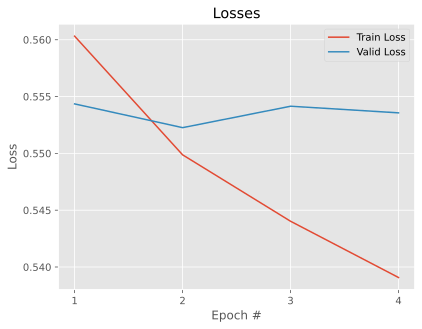

In [15]:
# This plot will visualize the model's loss over the epochs it was trained for.
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

# 4.4. Understanding of the impact of layers and different parameters.

  - In this section you will explore the impact of hidden layers, the number of neurons in each hidden layer, the learning rate and loss functions. We will produce the training and validation losses to compare the graphs of different combinations to build up a deeper understanding of how all these parameters can have an impact on the overall classification performance.

  -  You are welcome to create your own number of hidden layers, experiment with it and observe the changes in the training and validation losses. In that case, don't forget to change the bow_model and FeedfowardTextClassifier class as well.

In [ ]:
# This exercise will take some time. Have patience.

HIDDEN_1 = [64, 128, 128] # change your parameters here
HIDDEN_2 = [128, 128, 128] # change your parameters here
HIDDEN_3 = [128, 512, 64] # change your parameters here
HIDDEN_4 = [128, 512, 64] # change your parameters here

LEARNING__RATE = [0.1, 0.01, 0.001] # change your parameters here
max_epochs =[5,5,5] # change your parameters here, you can keep the epocs same to comare the results for different set of experiments.

criterion = nn.CrossEntropyLoss() # try out different loss functions here. read documentaion for more

combination = 3
results = []

for i in range(combination) :
  print(f'training model for {i} combination of parameters.')

  HIDDEN1 = HIDDEN_1[i]
  HIDDEN2 = HIDDEN_2[i]
  HIDDEN3 = HIDDEN_3[i]
  HIDDEN4 = HIDDEN_4[i]
  LEARNING_RATE = LEARNING__RATE[i]

# Store results for each run

  # Initialize the model with current parameters
  bow_model = FeedfowardTextClassifier(
      vocab_size=len(dataset.token2idx),
      hidden1=HIDDEN1,
      hidden2=HIDDEN2,
      hidden3 = HIDDEN3,
      hidden4 = HIDDEN4,
      num_labels=2,
      device=device,
      batch_size=BATCH_SIZE,
  )

  # Convert learning_rate to float
  learning_rate = float(LEARNING_RATE)

  optimizer = optim.Adam(
      filter(lambda p: p.requires_grad, bow_model.parameters()),
      lr=learning_rate,
  )
  scheduler = CosineAnnealingLR(optimizer, 1)
  def train_epoch(model, optimizer, train_loader, input_type='bow'):
    model.train()
    total_loss, total = 0, 0
    for seq, bow, target, text in train_loader:
        if input_type == 'bow':
            inputs = bow

        # Reset gradient
        optimizer.zero_grad()

        # Forward pass
        output = model(inputs)

        # Compute loss
        loss = criterion(output, target)

        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += len(target)

    return total_loss / total


  def validate_epoch(model, valid_loader, input_type='bow'):
    model.eval()
    total_loss, total = 0, 0
    with torch.no_grad():
        for seq, bow, target, text in valid_loader:
            if input_type == 'bow':
                inputs = bow

            # Forward pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total += len(target)

    return total_loss / total

  n_epochs = 0
  train_losses, valid_losses = [], []
  while n_epochs <= max_epochs[i]:
      train_loss = train_epoch(bow_model, optimizer, train_loader, input_type='bow')
      valid_loss = validate_epoch(bow_model, valid_loader, input_type='bow')

      tqdm.write(
          f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
      )

      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      n_epochs += 1

  # Store the results for this run
  result_entry = {
      'combination': f' hidden1 = {HIDDEN1}, hidden2 = {HIDDEN2}, hidden3 = {HIDDEN3},\n  learning_rate = {LEARNING_RATE}, and epoch = {max_epochs[i]}'  ,
      'learning_rate': learning_rate,
      'max_epochs': max_epochs,
      'train_losses': train_losses,
      'valid_losses': valid_losses,
  }

  results.append(result_entry)

training model for 0 combination of parameters.
epoch #  1	train_loss: 1.48e-03	valid_loss: 1.48e-03

epoch #  2	train_loss: 1.48e-03	valid_loss: 1.48e-03

epoch #  3	train_loss: 1.48e-03	valid_loss: 1.48e-03

epoch #  4	train_loss: 1.48e-03	valid_loss: 1.48e-03

epoch #  5	train_loss: 1.48e-03	valid_loss: 1.48e-03

epoch #  6	train_loss: 1.48e-03	valid_loss: 1.48e-03

training model for 1 combination of parameters.
epoch #  1	train_loss: 1.06e-03	valid_loss: 1.05e-03

epoch #  2	train_loss: 1.04e-03	valid_loss: 1.05e-03



You can also play with `MAX_VOCAB` parameter that set the number of unique and most frequent words to include in our vocabulary. If you do so, you need to re-run some code blocks from above. Try to find which parameter configuration leads to better classification performance.

### Here we will produce the graphs to compare the and understand the results.

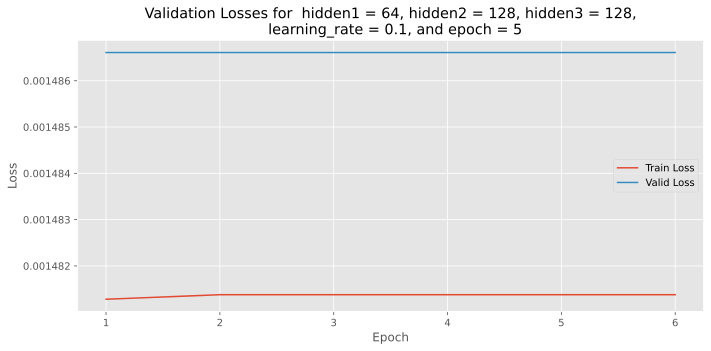

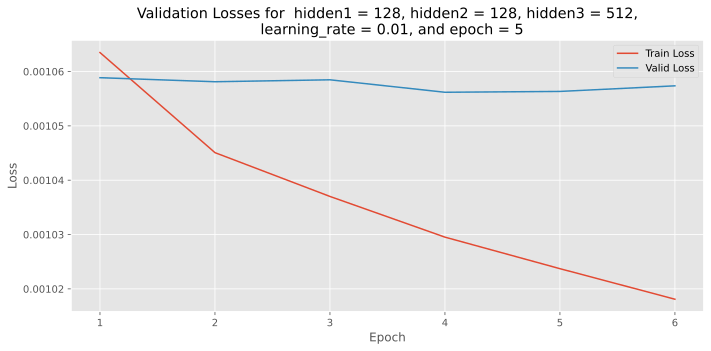

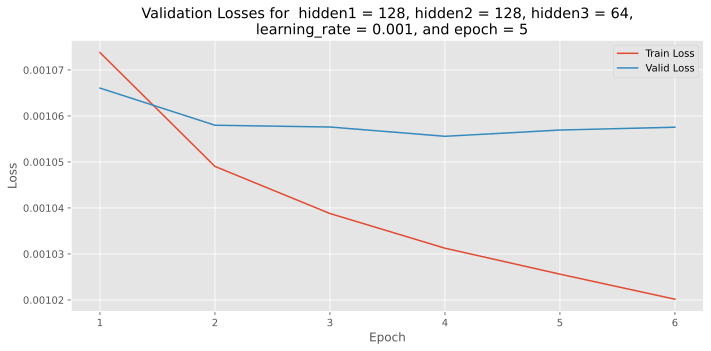

In [ ]:
for i, result in enumerate(results):
    # Extract relevant information
    combination = result['combination']
    learning_rate = result['learning_rate']
    max_epochs = result['max_epochs']
    train_losses = result['train_losses']
    valid_losses = result['valid_losses']

    plt.figure(figsize=(10, 5))

    # Plot training losses
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.title(f'Training Losses for {combination}')
    plt.plot(range(1, len(train_losses) + 1), valid_losses, label='Valid Loss')
    plt.title(f'Validation Losses for {combination}')
    plt.xticks(range(1, len(train_losses) + 1))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Explain the differences you see in the produced plots from your experiment. (3 Point)
  - What does training loss mean? (0.5 point)
  - What does validation loss mean? (0.5 point)
  - How does adding hidden layers impact the results? (0 point)
  - How do different parameters in each hidden layer impact the result? (0 point)
  - How can you evaluate a model from this training and validation graphs? Describe it in your own words. (0.5 point)
  - Can you give some intuitive explanations of overfitting and underfitting based on the graphs you produced? (0.5)
  - How does a very small and very large learning rate impact the training and
   validation loss? (1 point)


 **Your answers go here:**

 Training loss and validation loss are two metrics used to evaluate the performance of a machine learning model. Training loss is the error rate of the model on the training data, while validation loss is the error rate of the model on the validation data. The validation data is a subset of the training data that is not used during training, but is used to evaluate the model’s performance on unseen data.

Adding hidden layers to a neural network can improve its performance by allowing it to learn more complex representations of the input data.
However, adding too many hidden layers can lead to overfitting, where the model becomes too complex and starts to fit the noise in the training data instead of the underlying patterns. The number of neurons in each hidden layer and the activation function used in each layer can also impact the model’s performance.

To evaluate a model from its training and validation graphs, you should look for signs of overfitting or underfitting.
Overfitting occurs when the model performs well on the training data but poorly on the validation data and is therefore too adapted to the training data. This can be diagnosed from a plot where the training loss is lower than the validation loss, and the validation loss has a trend that suggests further improvements are possible.
Underfitting occurs when the model performs poorly on both the training and validation data. This can be diagnosed from a plot where both the training and validation losses are high and plateaued.
A good fit occurs when the model performs well on both the training and validation data. This can be diagnosed from a plot where the training and validation losses are both low and plateaued.

A very small learning rate can cause the model to converge slowly or get stuck in a local minimum, while a very large learning rate can cause the model to diverge and fail to converge. A good learning rate is one that allows the model to converge quickly and accurately.

# 5. Check Performance of BoW Model

<h1>Exercise 5.1</h1> (2 Points)<br> Calculate `precision`, `recall` and `f1-score` for each of the classes. As you learned in the lecture, those are common measures to define the quality of our classifier.

![](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)

In [ ]:
bow_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []
input_type = 'bow'

with torch.no_grad():
    for seq, bow, target, text in test_loader:
        inputs = bow
        probs = bow_model(inputs)

        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()

        y_true.extend(predictions)
        y_pred.extend(target)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71     21034
           1       0.80      0.74      0.77     28963

    accuracy                           0.74     49997
   macro avg       0.74      0.74      0.74     49997
weighted avg       0.75      0.74      0.74     49997



**Let's check a few examples!**

Checking them might help understand, what might still go wrong.

In [ ]:
flatten = lambda x: [sublst for lst in x for sublst in lst]
seq_lst, bow_lst, target_lst, text_lst = zip(*test_loader)
seq_lst, bow_lst, target_lst, text_lst = map(flatten, [seq_lst, bow_lst, target_lst, text_lst])
test_examples = list(zip(seq_lst, bow_lst, target_lst, text_lst))

def print_random_prediction(model, n=4, input_type='bow'):
    # prints prediction made by the model and the true value for n items.
    to_emoji = lambda x: '😄' if x else '😡'
    model.eval()
    rows = []
    for i in range(n):
        with torch.no_grad():
            seq, bow, target, text = random.choice(test_examples)
            target = target.item()

            inputs = bow
            probs = model([inputs])

            probs = probs.detach().cpu().numpy()
            prediction = np.argmax(probs, axis=1)[0]

            predicted = to_emoji(prediction)
            actual = to_emoji(target)

            row = f"""
            <tr>
            <td>{i+1}&nbsp;</td>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            """
            rows.append(row)

    rows_joined = '\n'.join(rows)
    table = f"""
    <table>
    <tbody>
    <tr>
    <td><b>Number</b>&nbsp;</td>
    <td><b>Review</b>&nbsp;</td>
    <td><b>Predicted</b>&nbsp;</td>
    <td><b>Actual</b>&nbsp;</td>
    </tr>{rows_joined}
    </tbody>
    </table>
    """
    display(HTML(table))

In [ ]:
print_random_prediction(bow_model, n=20, input_type='bow')

Number,Review,Predicted,Actual
1,"@EdWords not really from me, maybe some quotes...? have to finish some stuff during the sessions. and looking for inspiration for a ppt",😄,😄
2,"@pwrdbykimchi http://bit.ly/B0tMi this is the song i like. epik high- 1 minute, 1 second.",😄,😄
3,agnes you're the bombdiggity like that potatoe pizza that we both love,😄,😄
4,@StarrahPenzHitz LOL I wish I was around N those days,😡,😡
5,"Chilling in deri with the band, just ordered a lush pizza...now playing halo n listening to U2 whats everyone up to? anyone still up?",😄,😄
6,@nsummy You still up for the concert tonight?! You're a party animal! I can't keep up.,😡,😄
7,figuring this out.. I am new here..,😄,😄
8,At target with my mum. Happiness.,😄,😄
9,josiah/legend20x is here and its awesome,😄,😄
10,Attention: Testicles. That is all.,😄,😄


### Final task: Using the formula, calculate **precision**, **recall** and **f1-score** for the above 20 random predictions. <br> (1.5 points)

**Your answer goes here.**

precision = TP/ (FP + TP)

= 14 / (14 + 2) = 14/16 = 7/8


recall = TP/ (TP + FN)

= 14 / (14 + 1) = 14/15

f1 - score = 2 * (precision * recall) / (precision + recall)


= 2 * (7/8 * 14/15) / (7/8 + 14/15)

= 2 * (98/120) / (217/120)

= 2 * 14/31

=28/31

You are done, we hope that you learned something practical in this homework! 🎄
